## 转动旋钮 Turn The Knobs

Turn The Knobs概念借鉴自心灵哲学家Daniel Dennett的直觉泵一书,在这里我们转动旋钮,通过改变代码中的一些细微要素,来发掘整个实现过程里的隐含深意,更好地理解代码.
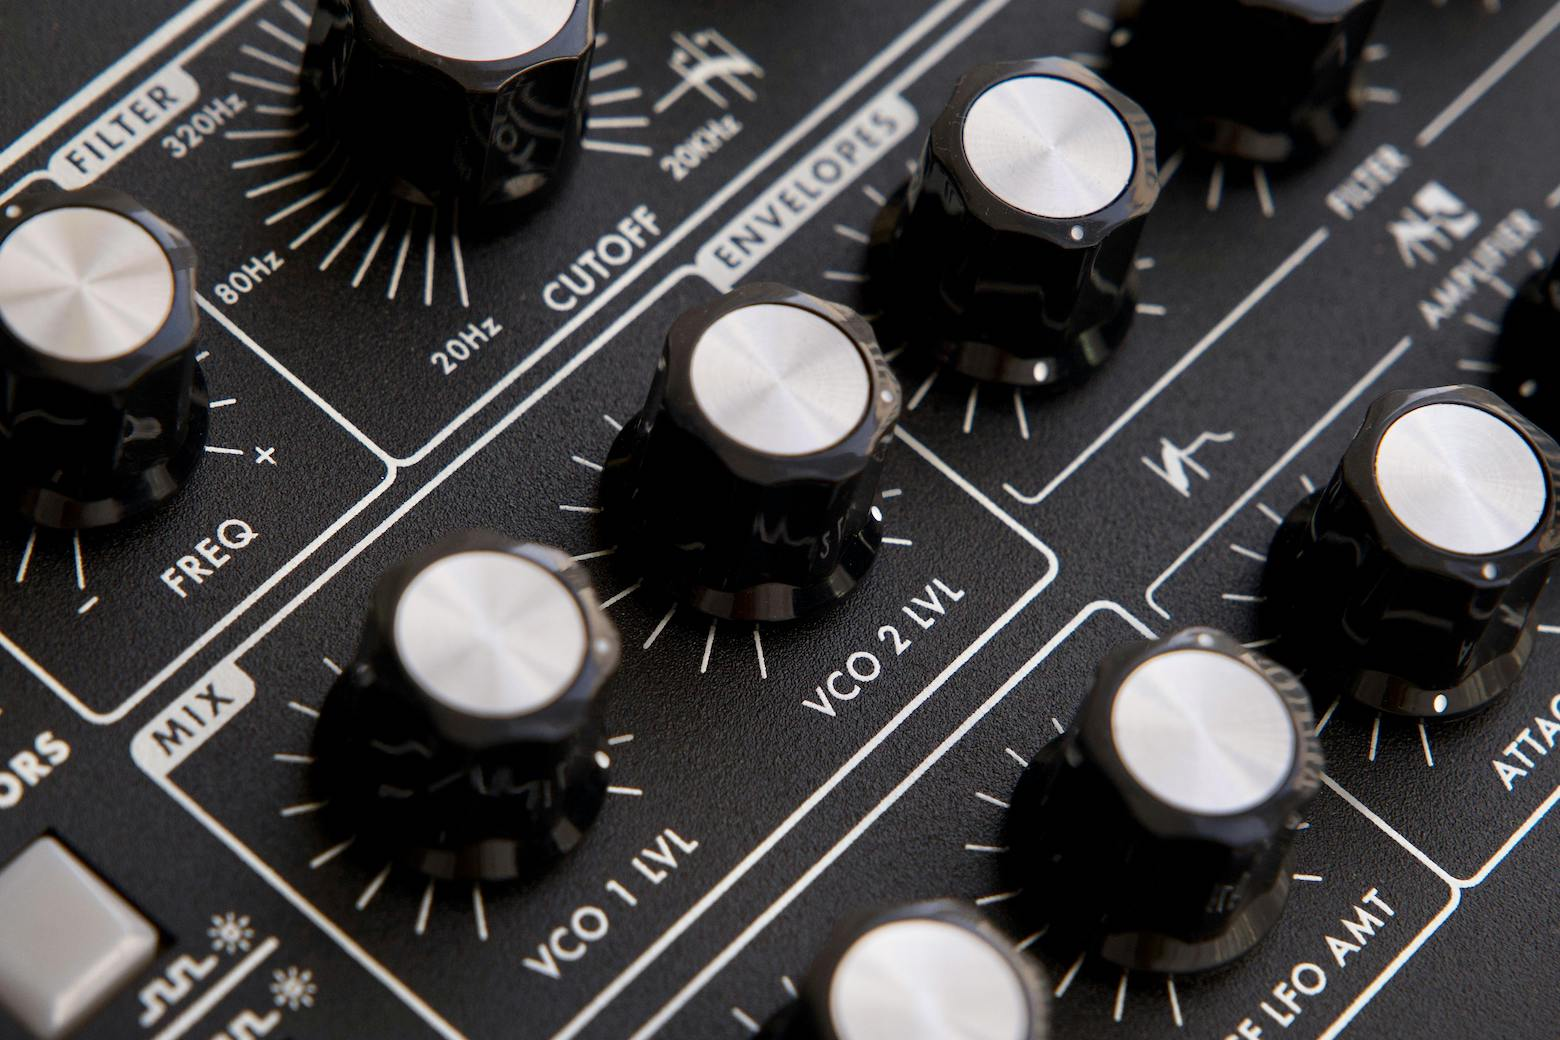

## 旋钮1：函数式编程中空函数 (The lambda: None Contract)
`Value` 在 `__init__` 中设置了 `self._backward = lambda: None`。这是一个“啥也不干”的函数。

问题： 为什么不直接设为 `self._backward = None`？`None` 岂不是更简单？

实验： 让我们定义一个 `BrokenValueV1`，它在初始化时使用 `None`。

In [51]:
class BrokenValueV1:
    def __init__(self, data):
        self.data = data
        self.grad = 0.0
        # 旋钮转动：我们把“啥也不干的函数”换成了“None”
        self._backward = lambda: None
        self._prev = set()
    
    def __repr__(self):
        return f"BrokenValueV1(data={self.data})"

    def backward(self):
        # 我们需要一个最小化的 backward() 来测试
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            # 这一行将会失败！
            node._backward()
            print (node._backward())

In [53]:
# 现在，让我们尝试对一个“叶子节点”b 进行反向传播
b = BrokenValueV1(5.0)


In [55]:
b.backward()

None


In [43]:
b.grad

1.0

backward（“总指挥官”）与 Value 之间有一个“契约”：“我保证 _backward 属性永远是一个可以被调用的东西。”

* lambda: None 是一个“可以被调用”的函数（它只是啥也不干），它遵守了契约。
* None 不是函数，它违背了契约。

lambda: None 是叶子节点最正确的 _backward 实现，它让“总指挥官”backward() 函数可以盲目地、自信地调用 node._backward()，而不需要 if node._backward is not None: 这样的丑陋检查。

## 旋钮2：闭包的“延迟执行” (_backward vs _backward())
在 __add__ 和__mul__中，我们设置了 out._backward = _backward（不带括号）。

问题： 如果加上了括号 out._backward = _backward()，会怎样？(这个 bug 在 Karpathy 的视频中也出现过)

实验： 我们加上这个()，然后执行从e 这个节点来运行backward()。

阶段一：前向传播 (您运行 `e = a*b` 时)
代码` e = a*b` 执行时，它调用了您改错的` __mul__ `方法。

在 __mul__ 内部，_backward 函数被定义了。

然后，电脑走到了您改错的那一行：out._backward = _backward() (带括号)。

因为有括号，_backward 函数被立即执行了。

我们来看看这个 _backward 函数：
```
def _backward():
  self.grad += other.data * out.grad
  other.grad += self.data * out.grad
```
这个函数没有 return 语句。

**在 Python 中，任何没有 return 语句的函数，在执行完毕后，都会默认返回 None。**

所以，out._backward = _backward() 这一行实际上等同于：e._backward = None。

阶段二：反向传播 (您运行 e.backward() 时)
您调用了 e.backward()。

backward 函数开始工作：

它构建了 topo 列表。对于 e 来说，topo 列表是 [a, b, e]。

e.grad 被设置成了 1.0。

for node in reversed(topo): 循环开始。

reversed(topo) 列表是 [e, b, a]。

第一个 node 就是 e。

代码执行到了 node._backward() 这一行。

此时，node 是 e。电脑尝试执行 e._backward()。

**但是，在阶段一中，我们已经确定了 e._backward 的值就是 None。**

所以，电脑实际上是在尝试执行 None()。

这就导致了您看到的错误：TypeError: 'NoneType' object is not callable（类型错误：“NoneType”这个东西是不能被“调用”（加括号）的）。

## 旋钮3：多元链式法则 (+= vs. =)
我们来看 __add__ 方法。在它嵌套的 _backward 函数里，**为什么是 `+=`？为什么不是简单的 `=`？** 

#### 2\. 转动旋钮 (Turn the Knob)

> “我现在要**编辑** `Value` 类的定义。我将把 `__add__` 里面的 `+=`... **全部改成 `=`**。”
>
> **(您在视频中实际操作)**
>
> ```python
>   # (在 __add__ 的 _backward 中...)
>   self.grad = 1.0 * out.grad
>   other.grad = 1.0 * out.grad
> ```
>
> “好了，我改完了。我现在**重新运行** `Value` 类的这个单元格，让这个‘坏’的版本生效。”

#### 3\. 制造反馈 (Get Feedback)

> “Karpathy 在这个 Notebook 的*最后*为我们提供了一个完美的测试用例。我们直接跳到最后。”
>
> “就是这个例子： `b = a + a`。在数学上，$L = a + a = 2a$，所以 $\frac{dL}{da}$ 应该等于 2。”
>
> “我们来看看，用了我们‘坏’的 `Value` 类，会发生什么？”
>
> **(您在视频中运行这个单元格)**
>
> ```python
> # 重新运行这个在 notebook 中已有的单元格
> a = Value(3.0, label='a')
> b = a + a   ; b.label = 'b'
> b.backward()
> draw_dot(b)
> ```

#### 4\. 展示崩溃 (Show the Error / Wrong Answer)

> **(您指着 `draw_dot(b)` 的输出)**
>
> “**快看！`a` 的 `grad` 是 `1.0`！**”
>
> “在原始的、正确的 Notebook 中，这个值是 `2.0`。我们把它搞砸了。**但为什么？**”

#### 5\. 解释 (Explain)

> “这背后就是多元链式法则的魔力。”
>
> “当我们运行 `b = a + a` 时，`a` 这个变量被同时作为 `self` *和* `other` 传给了 `__add__` 方法。”
>
> “所以，当 `b.backward()` 被调用时，`b` 的 `_backward`（那个被我们改坏的）开始执行：”
>
> 1.  “它执行第一行：`self.grad = 1.0 * b.grad`。`b.grad` 是 1.0。于是 `a.grad` 就被**设置**成了 `1.0`。”
> 2.  “然后它执行第二行：`other.grad = 1.0 * b.grad`。`other` 也是 `a`！于是 `a.grad` **又被设置**成了 `1.0`。”
>
> “它**覆盖**了！它没有累加。”
>
> “而**正确**的 `+=` 会做什么呢？”
>
> 1.  “`a.grad = a.grad + (1.0 * b.grad)` (即 `a.grad = 0.0 + 1.0 = 1.0`)”
> 2.  “`a.grad = a.grad + (1.0 * b.grad)` (即 `a.grad = 1.0 + 1.0 = 2.0`)”
>
> “这，就是 `+=` 的全部意义。当一个变量（`a`）通过**多条路径**影响了最终输出时，它的总梯度必须是**所有路径梯度的总和**。`+=` 正是‘累加’(accumulate)这个动作的完美代码实现。”

## 旋钮4：反向传播的“种子” (The self.grad = 1.0 Seed)
旋钮四：反向传播的“种子” (The `self.grad = 1.0` Seed)

**目标：** 理解为什么 `backward()` 函数**必须**以 `self.grad = 1.0` 开始。

**1. 锚定 (Anchor)：**

> “我们来看 `backward()` 这个‘总指挥官’函数。在 `topo` 列表被构建和反转之后，`for` 循环 开始之前，有这一行关键代码：`self.grad = 1.0`。”
>
> “我们总在说 $\frac{dL}{dL} = 1$。这行代码就是它的实现。但如果……我们不设置它呢？”

**2. 转动旋钮 (Turn the Knob)：**

> “我现在**编辑** `Value` 类的 `backward` 方法。我就把 `self.grad = 1.0` 这一行**注释掉**。”
>
> **(您在视频中实际操作)**
>
>   def backward(self):
>     # ... build_topo(self) ...
>     
>     # self.grad = 1.0  <--- 我把它注释掉了！
>     for node in reversed(topo):
>       node._backward()
> ```
>
> “好了，我重新运行 `Value` 类的单元格。”

**3. 制造反馈 & 4. 展示崩溃：**

> “现在，我们来运行 Karpathy 的原始例子 `L = d * f`，然后调用 `L.backward()`，最后 `draw_dot(L)`。”
>
> **(您运行 `L.backward()` 和 `draw_dot(L)` 所在的单元格)**
>
> “**快看！所有的 `grad` 都是 `0.0`！**”
>
> “`L.grad` 是 `0.0`，`f.grad` 是 `0.0`，`a.grad` 是 `0.0`... 整个反向传播**完全失败**了！”

**5. 解释 (Explain)：**

> “为什么？因为在 `__init__` 中，每个 `Value` 对象的 `grad` 都被**初始化为 `0.0`**。”
>
> “当我们注释掉 `L.grad = 1.0` 之后，`L.grad` 保持为 `0.0`。”
>
> “当 `L` 的 `_backward` 被调用时，它执行：`f.grad += d.data * L.grad`。这变成了 `f.grad += 4.0 * 0.0`... 结果还是 `0.0`！”
>
> “这个 `0.0` 的梯度会沿着链条一路乘下去，把所有梯度都变成了 0。**反向传播的‘链式反应’根本没有‘种子’来启动！**”
>
> “`self.grad = 1.0` 就是那个启动一切的‘种子’，它代表 $\frac{dL}{dL}$。”

## 旋钮5：实时跟踪 `topo` 和 `visited`

**目标：** 通过 `print` 语句，实时观察 `topo` 和 `visited` 列表，来搞清楚整个递归的过程,明白 `append` 是在子节点递归**完成之后**才发生的。

#### 1\. 转动旋钮 (Turn the Knob)

> **(在视频中)：** “我们现在要做一个最有趣的实验。我们要‘黑入’ `backward` 函数，在 `build_topo` 内部加上‘监视器’。我们将实时打印 `visited` 和 `topo` 列表，看看它们到底是怎么被填满的。”

**操作：**
请**复制**下面这个**完整**的 `Value` 类定义，并用它**替换**您 Notebook 中旧的 `Value` 类单元格。

这个版本**唯一**的改动就是在 `backward` 方法中添加了 `print` 语句。

In [42]:
# --- 复制这个完整的类 ---

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  # --- 这就是我们修改的地方！---
  def backward(self):
    
    topo = []
    visited = set()
    
    def build_topo(v):
      print(f"--- 检查节点: {v.label}")
      if v not in visited:
        visited.add(v)
        
        # --- 🔧 旋钮：打印 visited 状态 ---
        print(f"    ➡️  {v.label} 已添加.  VISITED 现为: {[n.label for n in visited]}")
        
        for child in v._prev:
            print(f"    ... ( {v.label} ) 准备递归其子节点 {child.label}")
            build_topo(child)
        
        topo.append(v)
        
        # --- 🔧 旋钮：打印 topo 状态 ---
        print(f"    ⬅️  {v.label} (及其所有子节点) 已完成.  TOPO 现为: {[n.label for n in topo]}")
        
      else:
        print(f"    ( {v.label} 已在 visited 中, 跳过 )")

    
    print("--- [backward] 开始：从 'self' (即 L) 启动 build_topo ---")
    build_topo(self)
    print("--- [backward] build_topo 完成 ---")
    
    print(f"\n--- [backward] 最终 TOPO 列表: {[n.label for n in topo]}")
    
    self.grad = 1.0
    
    reversed_list = list(reversed(topo))
    print(f"--- [backward] REVERSED TOPO 列表 (用于循环): {[n.label for n in reversed_list]}")

    print("\n--- [backward] 开始反向传播循环... ---")
    for node in reversed_list:
      node._backward()
    print("--- [backward] 反向传播循环 结束 ---")

# --- (可视化函数，保持不变) ---
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

-----

#### 2\. 制造反馈 (运行 Karpathy 的例子)

现在，**重新运行 `Value` 类单元格**，然后运行 `L = d * f` 的单元格和 `L.backward()` 单元格。

In [45]:
# 运行这个已有的单元格
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [47]:
# 现在运行这个
L.backward()

--- [backward] 开始：从 'self' (即 L) 启动 build_topo ---
--- 检查节点: L
    ➡️  L 已添加.  VISITED 现为: ['L']
    ... ( L ) 准备递归其子节点 d
--- 检查节点: d
    ➡️  d 已添加.  VISITED 现为: ['d', 'L']
    ... ( d ) 准备递归其子节点 e
--- 检查节点: e
    ➡️  e 已添加.  VISITED 现为: ['d', 'e', 'L']
    ... ( e ) 准备递归其子节点 a
--- 检查节点: a
    ➡️  a 已添加.  VISITED 现为: ['a', 'd', 'e', 'L']
    ⬅️  a (及其所有子节点) 已完成.  TOPO 现为: ['a']
    ... ( e ) 准备递归其子节点 b
--- 检查节点: b
    ➡️  b 已添加.  VISITED 现为: ['d', 'b', 'a', 'L', 'e']
    ⬅️  b (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b']
    ⬅️  e (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b', 'e']
    ... ( d ) 准备递归其子节点 c
--- 检查节点: c
    ➡️  c 已添加.  VISITED 现为: ['d', 'c', 'b', 'a', 'L', 'e']
    ⬅️  c (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b', 'e', 'c']
    ⬅️  d (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b', 'e', 'c', 'd']
    ... ( L ) 准备递归其子节点 f
--- 检查节点: f
    ➡️  f 已添加.  VISITED 现为: ['d', 'c', 'f', 'b', 'a', 'L', 'e']
    ⬅️  f (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b', 'e', 'c', 'd', 'f']
    ⬅️  L (及其所有子节点) 已完成.  TOPO 现为: ['a', 'b', 'e', 

-----

#### 3\. 解释 (Explain) - 这是最关键的部分

> **(您在视频中指着打印输出)**
> “好的，我们来看这个输出，这正是‘旋钮六’的答案。”
>
> 1.  “`backward` 从 `L` 开始。`L` 被添加到 `VISITED`。”
> 2.  “`L` 准备递归它的子节点 `d`。”
> 3.  “`d` 被添加到 `VISITED`。”
> 4.  “`d` 准备递归它的子节点 `e`。”
> 5.  “`e` 被添加到 `VISITED`。”
> 6.  “`e` 准备递归它的子节点 `a`。”
> 7.  “`a` 被添加到 `VISITED`。”
> 8.  “`a` 没有子节点。递归结束。”
> 9.  “**现在看这里！** `TOPO` 列表出现了，**第一个**被添加进去的节点是 `a`！**这证明了 `append` 是在递归‘返回’时才执行的。**”
>
> “`a` 完成后，`e` 的循环继续，递归 `b`。”
>
> 1.  “`b` 被添加到 `VISITED`。”
> 2.  “`b` 没有子节点，它被添加到 `TOPO`。”
>
> “现在，`e` 的*所有*子节点（`a` 和 `b`）都完成了。**现在**，`e` 才能被添加到 `TOPO`。”
>
> “这个过程会一直持续... `c` 被添加... `d` 被添加... `f` 被添加...”
>
> “**直到最后**，`L` 的所有子节点都完成了，`L` 才是**最后一个**被添加到 `TOPO` 列表的。”
>
> “**这正是我们想要的！** `最终 TOPO 列表` 是 `['a', 'b', 'e', 'c', 'd', 'f', 'L']`。这是一个**完美的前向计算顺序**。所以，`reversed()` 才能把它变成一个**完美的反向传播顺序** `['L', 'f', 'd', 'c', 'e', 'b', 'a']`。”